In [4]:
import numpy as np
import pickle
import os
import glob
import torch
from torch.utils.data import DataLoader, Dataset
import re

In [5]:
class CustomScaler:
    def __init__(self):
        self.u_min = float('inf')
        self.u_max = float('-inf')
    
    def partial_fit(self, batch):
        batch_min = np.min(batch)
        batch_max = np.max(batch)
        self.u_min = min(self.u_min, batch_min)
        self.u_max = max(self.u_max, batch_max)
    
    def fit(self, data_loader):
        for i, batch in enumerate(data_loader):
            self.partial_fit(batch.numpy())
            if i % 10 == 0:  # Print every 10 batches
                print(f"Batch {i}, Current min: {self.u_min:.6f}, Current max: {self.u_max:.6f}")
    
    def transform(self, u):
        u_scaled = (2 * u - (self.u_max + self.u_min)) / (self.u_max - self.u_min)
        return np.clip(u_scaled, -1, 1)
    
    def untransform(self, u_scaled):
        return 0.5 * (u_scaled * (self.u_max - self.u_min) + (self.u_max + self.u_min))

class GANDataset(Dataset):
    def __init__(self, folder_path, prefix):
        self.folder_path = folder_path
        self.prefix = prefix
        self.num_timesteps = 500  # 0 to 499

    def __len__(self):
        return self.num_timesteps

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder_path, f'{self.prefix}_sample_{idx}.npy')
        data = np.load(file_path)
        return torch.from_numpy(data[2]).float()  # u = [0], v = [1] , w = [2]                       <--

def create_dataloader(dataset, batch_size=32):
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

def save_scaler(scaler, path):
    with open(path, 'wb') as f:
        pickle.dump(scaler, f)

def load_scaler(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def fit_scaler(gen_folder_path, disc_folder_path, scaler_path, batch_size=500):                     # <--
    print(f"Fitting scaler with batch size: {batch_size}")
    scaler = CustomScaler()

    # Create DataLoaders
    gen_dataset = GANDataset(gen_folder_path, 'g')
    disc_dataset = GANDataset(disc_folder_path, 'd')

    gen_loader = create_dataloader(gen_dataset, batch_size)
    disc_loader = create_dataloader(disc_dataset, batch_size)

    # Fit the single scaler on both datasets
    print("Fitting scaler on generator data...")
    scaler.fit(gen_loader)
    print("Fitting scaler on discriminator data...")
    scaler.fit(disc_loader)

    # Save the scaler
    save_scaler(scaler, scaler_path)
    print(f"Scaler saved to {scaler_path}")
    
    return scaler

In [50]:
# u velocity norm
gen_folder_path = r'H:\DDGAN\samples_g'
disc_folder_path = r'H:\DDGAN\samples_d'
scaler_path = r'H:\DDGAN\scaler_u.pkl'

# Check if a saved scaler exists
if os.path.exists(scaler_path):
    print("Loading existing scaler...")
    scaler = load_scaler(scaler_path)
else:
    print("Creating and fitting new scaler...")
    scaler = fit_scaler(gen_folder_path, disc_folder_path, scaler_path)

print(f"Final Data min: {scaler.u_min:.6f}, Data max: {scaler.u_max:.6f}")

Creating and fitting new scaler...
Fitting scaler with batch size: 500
Fitting scaler on generator data...
Batch 0, Current min: -5.770183, Current max: 6.928477
Fitting scaler on discriminator data...
Batch 0, Current min: -5.770183, Current max: 6.928477
Scaler saved to H:\DDGAN\scaler_u.pkl
Final Data min: -5.770183, Data max: 6.928477


In [53]:
# v velocity norm
gen_folder_path = r'H:\DDGAN\samples_g'
disc_folder_path = r'H:\DDGAN\samples_d'
scaler_path = r'H:\DDGAN\scaler_v.pkl'

# Check if a saved scaler exists
if os.path.exists(scaler_path):
    print("Loading existing scaler...")
    scaler = load_scaler(scaler_path)
else:
    print("Creating and fitting new scaler...")
    scaler = fit_scaler(gen_folder_path, disc_folder_path, scaler_path)

print(f"Final Data min: {scaler.u_min:.6f}, Data max: {scaler.u_max:.6f}")

Creating and fitting new scaler...
Fitting scaler with batch size: 500
Fitting scaler on generator data...
Batch 0, Current min: -6.961655, Current max: 6.317091
Fitting scaler on discriminator data...
Batch 0, Current min: -6.961655, Current max: 6.317091
Scaler saved to H:\DDGAN\scaler_v.pkl
Final Data min: -6.961655, Data max: 6.317091


In [56]:
# w velocity norm
gen_folder_path = r'H:\DDGAN\samples_g'
disc_folder_path = r'H:\DDGAN\samples_d'
scaler_path = r'H:\DDGAN\scaler_w.pkl'

# Check if a saved scaler exists
if os.path.exists(scaler_path):
    print("Loading existing scaler...")
    scaler = load_scaler(scaler_path)
else:
    print("Creating and fitting new scaler...")
    scaler = fit_scaler(gen_folder_path, disc_folder_path, scaler_path)

print(f"Final Data min: {scaler.u_min:.6f}, Data max: {scaler.u_max:.6f}")

Creating and fitting new scaler...
Fitting scaler with batch size: 500
Fitting scaler on generator data...
Batch 0, Current min: -6.189626, Current max: 4.068191
Fitting scaler on discriminator data...
Batch 0, Current min: -6.189626, Current max: 4.068191
Scaler saved to H:\DDGAN\scaler_w.pkl
Final Data min: -6.189626, Data max: 4.068191


In [46]:
# building matrix
building_path = r'H:\DDGAN\samples_h'
scaler_path = r'H:\DDGAN\h_scaler.pkl'

# Check if a saved scaler exists
if os.path.exists(scaler_path):
    print("Loading existing scaler...")
    scaler = load_scaler(scaler_path)
else:
    print("Creating and fitting new scaler...")
    scaler = CustomScaler()

    # Create DataLoaders
    h_dataset = GANDataset(building_path, 'h')
    h_loader = create_dataloader(h_dataset)

    # Fit the single scaler on both datasets
    print("Fitting scaler on building data...")
    scaler.fit(h_loader)

    # Save the scaler
    save_scaler(scaler, scaler_path)
    print(f"Scaler saved to {scaler_path}")

print(f"Data min: {scaler.u_min}, Data max: {scaler.u_max}")

Creating and fitting new scaler...
Fitting scaler on building data...
Scaler saved to H:\DDGAN\h_scaler.pkl
Data min: 0.0, Data max: 17.200000762939453


In [64]:
""""
This section is for finding the min and max from the dataset
for checking the scaler output
"""

def find_min_max_all_first_matrices(folder_path, prefix):
    file_pattern = os.path.join(folder_path, f'{prefix}_sample_*.npy')
    all_files = sorted(glob.glob(file_pattern))
    
    if not all_files:
        print(f"No files found matching the pattern: {file_pattern}")
        return None, None

    global_min = float('inf')
    global_max = float('-inf')
    
    for file in all_files:
        data = np.load(file)
        u_matrix = data[0]
        global_min = min(global_min, np.min(u_matrix))
        global_max = max(global_max, np.max(u_matrix))

    return global_min, global_max

samples_g_folder = r'H:\DDGAN\samples_d'
min_val, max_val = find_min_max_all_first_matrices(samples_g_folder, 'd')
print(f"Across all first matrices in samples_d:")
print(f"Global minimum value: {min_val}")
print(f"Global maximum value: {max_val}")


Across all first matrices in samples_d:
Global minimum value: -4.611507892608643
Global maximum value: 6.729224681854248


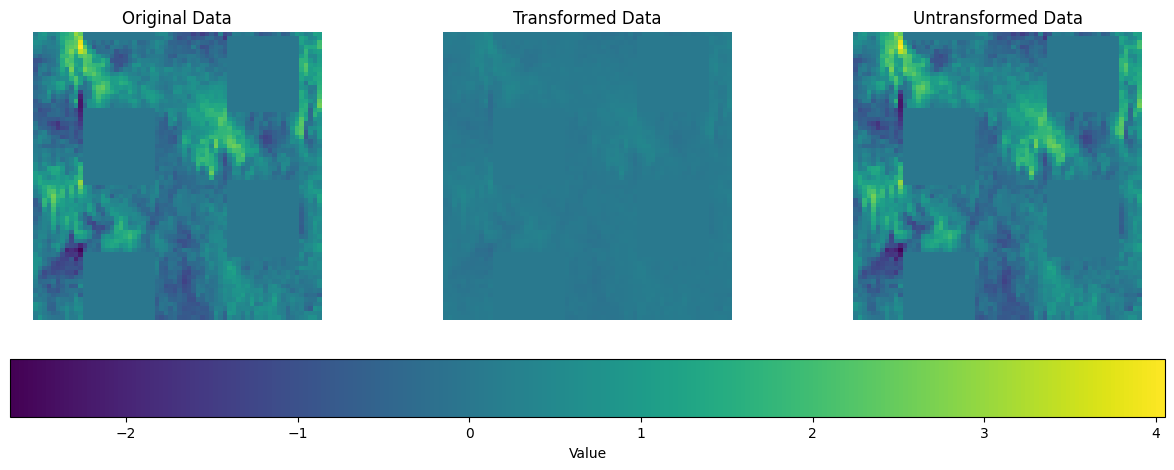

Sample data range: [-2.6760, 4.0514]
Transformed data range: [-0.3545, 0.6587]
Untransformed data range: [-2.6760, 4.0514]

Untransformed data matches original data: False
Max absolute difference: 2.3841858e-07


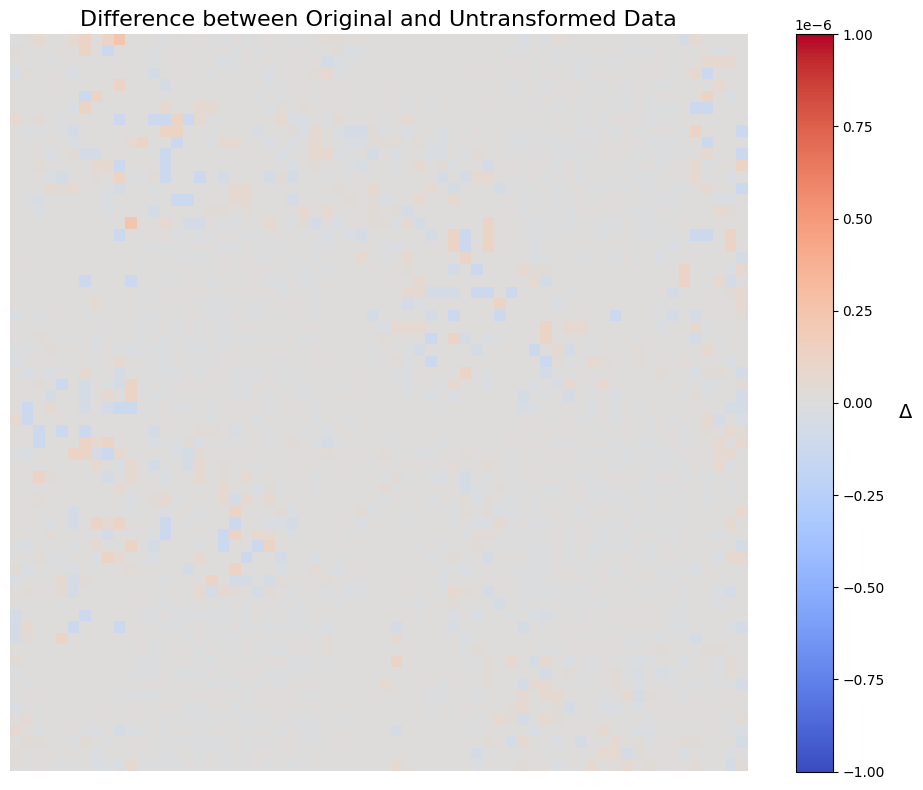

Mean absolute difference: 1.23e-08
Median absolute difference: 2.50e-09
Standard deviation of difference: 2.67e-08


In [58]:
# Testing scaler
def load_scaler(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# Paths
scaler_path = r'H:\DDGAN\scaler_v.pkl'
sample_path = r'H:\DDGAN\samples_d\d_sample_100.npy'

# Load the scaler
scaler = load_scaler(scaler_path)
sample_data = np.load(sample_path)[1]  # [0] to get the first matrix
transformed_data = scaler.transform(sample_data)

def untransform(self, u_scaled):
    return 0.5 * (u_scaled * (self.u_max - self.u_min) + (self.u_max + self.u_min))

scaler.untransform = untransform.__get__(scaler)
untransformed_data = scaler.untransform(transformed_data)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
global_min = min(np.min(sample_data), np.min(transformed_data), np.min(untransformed_data))
global_max = max(np.max(sample_data), np.max(transformed_data), np.max(untransformed_data))

im1 = ax1.imshow(sample_data, cmap='viridis', vmin=global_min, vmax=global_max)
ax1.set_title('Original Data')
ax1.axis('off')

im2 = ax2.imshow(transformed_data, cmap='viridis', vmin=global_min, vmax=global_max)
ax2.set_title('Transformed Data')
ax2.axis('off')

im3 = ax3.imshow(untransformed_data, cmap='viridis', vmin=global_min, vmax=global_max)
ax3.set_title('Untransformed Data')
ax3.axis('off')

cbar = fig.colorbar(im1, ax=[ax1, ax2, ax3], orientation='horizontal', pad=0.1)
cbar.set_label('Value')

plt.show()

print(f"Sample data range: [{np.min(sample_data):.4f}, {np.max(sample_data):.4f}]")
print(f"Transformed data range: [{np.min(transformed_data):.4f}, {np.max(transformed_data):.4f}]")
print(f"Untransformed data range: [{np.min(untransformed_data):.4f}, {np.max(untransformed_data):.4f}]")

# Check if the untransformed data matches the original data
is_close = np.allclose(sample_data, untransformed_data)
print("\nUntransformed data matches original data:", is_close)

if not is_close:
    print("Max absolute difference:", np.max(np.abs(sample_data - untransformed_data)))


# Calculate the difference
difference = sample_data - untransformed_data



plt.figure(figsize=(10, 8))
plt.imshow(difference, cmap='coolwarm', norm=plt.Normalize(vmin=-1e-6, vmax=1e-6))
cbar = plt.colorbar(label=r'$\Delta$')  # Note the 'r' before the string
cbar.set_label(r'$\Delta$', rotation=0, labelpad=15, fontsize=14)  # Note the 'r' before the string

plt.title(r'Difference between Original and Untransformed Data', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Mean absolute difference: {np.mean(np.abs(difference)):.2e}")
print(f"Median absolute difference: {np.median(np.abs(difference)):.2e}")
print(f"Standard deviation of difference: {np.std(difference):.2e}")

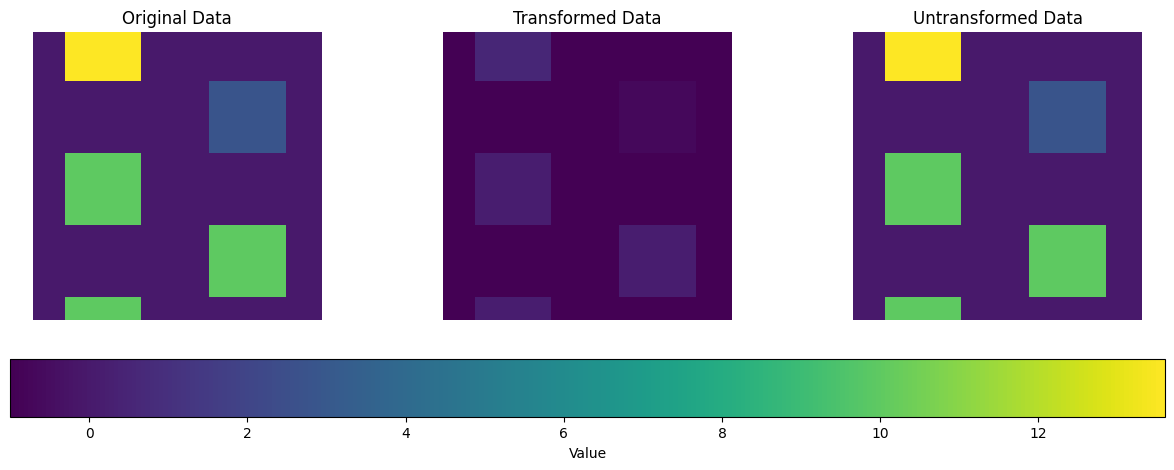

Sample data range: [0.0000, 13.6000]
Transformed data range: [-1.0000, 0.5814]
Untransformed data range: [0.0000, 13.6000]

Untransformed data matches original data: True


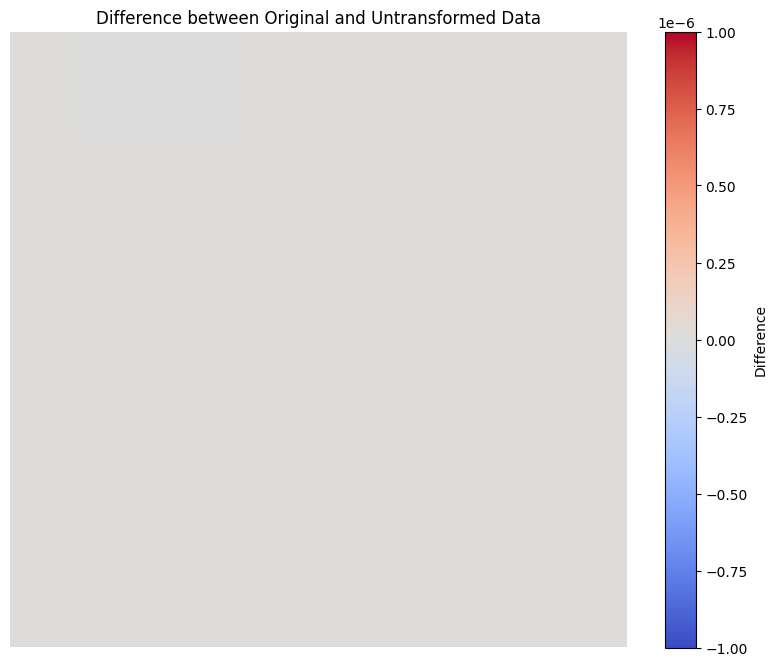

Mean absolute difference: 8.11e-17
Median absolute difference: 0.00e+00
Standard deviation of difference: 3.71e-16


In [47]:
# Testing scaler

import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

def load_scaler(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# Paths
scaler_path = r'H:\DDGAN\h_scaler.pkl'
sample_path = r'H:\DDGAN\samples_h\h_sample_0.npy'

# Load the scaler
scaler = load_scaler(scaler_path)
sample_data = np.load(sample_path)[0]  
transformed_data = scaler.transform(sample_data)

def untransform(self, u_scaled):
    return 0.5 * (u_scaled * (self.u_max - self.u_min) + (self.u_max + self.u_min))

scaler.untransform = untransform.__get__(scaler)
untransformed_data = scaler.untransform(transformed_data)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
global_min = min(np.min(sample_data), np.min(transformed_data), np.min(untransformed_data))
global_max = max(np.max(sample_data), np.max(transformed_data), np.max(untransformed_data))

im1 = ax1.imshow(sample_data, cmap='viridis', vmin=global_min, vmax=global_max)
ax1.set_title('Original Data')
ax1.axis('off')

im2 = ax2.imshow(transformed_data, cmap='viridis', vmin=global_min, vmax=global_max)
ax2.set_title('Transformed Data')
ax2.axis('off')

im3 = ax3.imshow(untransformed_data, cmap='viridis', vmin=global_min, vmax=global_max)
ax3.set_title('Untransformed Data')
ax3.axis('off')

cbar = fig.colorbar(im1, ax=[ax1, ax2, ax3], orientation='horizontal', pad=0.1)
cbar.set_label('Value')

plt.show()

# Print some statistics
print(f"Sample data range: [{np.min(sample_data):.4f}, {np.max(sample_data):.4f}]")
print(f"Transformed data range: [{np.min(transformed_data):.4f}, {np.max(transformed_data):.4f}]")
print(f"Untransformed data range: [{np.min(untransformed_data):.4f}, {np.max(untransformed_data):.4f}]")

# Check if the untransformed data matches the original data
is_close = np.allclose(sample_data, untransformed_data)
print("\nUntransformed data matches original data:", is_close)

if not is_close:
    print("Max absolute difference:", np.max(np.abs(sample_data - untransformed_data)))


# Calculate the difference
difference = sample_data - untransformed_data

# Plot the difference
plt.figure(figsize=(10, 8))
plt.imshow(difference, cmap='coolwarm', norm=plt.Normalize(vmin=-1e-6, vmax=1e-6))
plt.colorbar(label='Difference')
plt.title('Difference between Original and Untransformed Data')
plt.axis('off')
plt.show()

# Print some statistics about the difference
print(f"Mean absolute difference: {np.mean(np.abs(difference)):.2e}")
print(f"Median absolute difference: {np.median(np.abs(difference)):.2e}")
print(f"Standard deviation of difference: {np.std(difference):.2e}")

In [1]:
import numpy as np
import pickle
import os
import glob

def load_scaler(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# Paths
scalers_path = r'H:\DDGAN\plus_height'                                                  # <--
input_folder = r'H:\DDGAN\plus_height\samples_g'                                        # <--
output_folder = r'H:\DDGAN\plus_height\norm_g_ph'                                          # <--

# Load scalers
u_scaler = load_scaler(os.path.join(scalers_path, 'scaler_u.pkl'))
v_scaler = load_scaler(os.path.join(scalers_path, 'scaler_v.pkl'))
w_scaler = load_scaler(os.path.join(scalers_path, 'scaler_w.pkl'))

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Get list of input files
input_files = glob.glob(os.path.join(input_folder, 'd_sample_*.npy'))       # <--

for input_file in input_files:
    # Load the data
    data = np.load(input_file)
    
    # Extract filename
    filename = os.path.basename(input_file)
    
    # Transform each matrix
    transformed_data = np.array([
        u_scaler.transform(data[0]),
        v_scaler.transform(data[1]),
        w_scaler.transform(data[2])
    ])

    # transformed_data = np.array([
    #     h_scaler.transform(data)
    # ])
    
    # Save transformed data
    output_file = os.path.join(output_folder, f'norm_{filename}')
    np.save(output_file, transformed_data)
    
    print(f"Processed and saved: {output_file}")
    
    # Check output file
    loaded_data = np.load(output_file)
    print(f"Output file shape: {loaded_data.shape}")
    print(f"Minimum value: {np.min(loaded_data)}")
    print(f"Maximum value: {np.max(loaded_data)}")
    print("---")

print("All files processed.")

AttributeError: Can't get attribute 'CustomScaler' on <module '__main__'>

In [ ]:
"""
For building matrix only
"""
def load_scaler(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

scalers_path = r'H:\DDGAN'
input_folder = r'H:\DDGAN\samples_h'
output_folder = r'H:\DDGAN\norm_h'
h_scaler = load_scaler(os.path.join(scalers_path, 'h_scaler.pkl'))
os.makedirs(output_folder, exist_ok=True)
input_files = glob.glob(os.path.join(input_folder, 'h_sample_*.npy'))

for input_file in input_files:
    # Load the data
    data = np.load(input_file)
    filename = os.path.basename(input_file)
    transformed_data = h_scaler.transform(data)
    transformed_data = transformed_data.reshape(1, 64, 64)
    output_file = os.path.join(output_folder, f'norm_{filename}')
    np.save(output_file, transformed_data)
    print(f"Processed and saved: {output_file}")
    loaded_data = np.load(output_file)
    print(f"Output file shape: {loaded_data.shape}")
    print(f"Minimum value: {np.min(loaded_data)}")
    print(f"Maximum value: {np.max(loaded_data)}")
    print("---")

print("All files processed.")

In [ ]:
"""
Stacking the matrix
"""
# Paths
norm_g_folder = r'H:\DDGAN\norm_g'
norm_h_folder = r'H:\DDGAN\norm_h'
output_file = r'H:\DDGAN\norm_generator_full'
os.makedirs(output_file, exist_ok=True)

def extract_timestep(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else None

g_files = sorted(glob.glob(os.path.join(norm_g_folder, 'norm_g_sample_*.npy')), key=extract_timestep)
h_files = sorted(glob.glob(os.path.join(norm_h_folder, 'norm_h_sample_*.npy')), key=extract_timestep)

if len(g_files) != len(h_files):
    print(f"Warning: Number of files in norm_g ({len(g_files)}) and norm_h ({len(h_files)}) folders don't match.")

z = 0

for g_file, h_file in zip(g_files, h_files):
    g_timestep = extract_timestep(g_file)
    h_timestep = extract_timestep(h_file)
    
    # chcek file number
    if g_timestep != h_timestep:
        print(f"Warning: Timestep mismatch between {g_file} and {h_file}")
        continue
    
    # Load the data
    g_data = np.load(g_file)
    h_data = np.load(h_file)

    print("---")
    print(f"Processing timestep {g_timestep}:")
    print(f"  G file: {os.path.basename(g_file)}, shape: {g_data.shape}")
    print(f"  H file: {os.path.basename(h_file)}, shape: {h_data.shape}")
    
    h_matrix = h_data[0]
    u_matrix = g_data[0]
    v_matrix = g_data[1]
    w_matrix = g_data[2]
    new_u_matrix = np.vstack([u_matrix, h_matrix])
    new_v_matrix = np.vstack([v_matrix, h_matrix])
    new_w_matrix = np.vstack([w_matrix, h_matrix])

    print(f"new u shape: {new_u_matrix.shape}")
    print(f"new v shape: {new_v_matrix.shape}")
    print(f"new w shape: {new_w_matrix.shape}")

    
    print("---")
    np.save(os.path.join(output_file, f"norm_gen_{z}.npy"), [new_u_matrix, new_v_matrix, new_w_matrix])
    z += 1
    
print("All paired files processed.")

In [67]:
"""
Testing the stacked matrix 
"""
test = r'H:\DDGAN\norm_generator_full\norm_gen_1.npy'
test_data = np.load(test)
u = test_data[0]
v = test_data[1]
w = test_data[2]
matrix_list = (u,v,w)
def plot_matrices(matrix_list):
    """
    plot function
    """
    num_matrices = len(matrix_list)
    fig, axes = plt.subplots(1, num_matrices, figsize=(200, 100))
    for i, matrix in enumerate(matrix_list):
        if num_matrices == 1:
            ax = axes
        else:
            ax = axes[i]
        cax = ax.imshow(matrix, cmap='viridis', aspect='equal')
        ax.set_title(f'Matrix {i + 1}')
        ax.set_xlabel('Column Index')
        ax.set_ylabel('Row Index')
    plt.tight_layout()
    plt.show()

plot_matrices(matrix_list)
print(f"Sample data range: [{np.min(u):.4f}, {np.max(u):.4f}]")
print(f"Sample data range: [{np.min(v):.4f}, {np.max(v):.4f}]")
print(f"Sample data range: [{np.min(w):.4f}, {np.max(w):.4f}]")

Sample data range: [-1.0000, 0.5814]
Sample data range: [-1.0000, 0.5822]
Sample data range: [-1.0000, 0.7354]
